## Installation

The project provides two main options for [installation](https://frgfm.github.io/Holocron/latest/installing.html): one for stable release and from source. 

## Latest stable release

The last stable release that was published by the author. It is expected to provide a clean and non-buggy experience for all users.

In [ ]:
# Pypi
!pip install pylocron
# Conda
# !conda install -c frgfm pylocron 

## From source

Before being staged for a stable release, many improvements are brought to the library thanks to the community's feedback. Bug fixes and performance improvements are regularly pushed to the project Git repository. Using this installation method, you will access all the latest features that have not yet made their way to a stable release!

In [2]:
# Install the most up-to-date version from GitHub
!pip install -e git+https://github.com/frgfm/Holocron.git#egg=pylocron

Obtaining pylocron from git+https://github.com/frgfm/Holocron.git#egg=pylocron
  Cloning https://github.com/frgfm/Holocron.git to ./src/pylocron
  Running command git clone -q https://github.com/frgfm/Holocron.git /content/src/pylocron
     |████████████████████████████████| 4.3 MB 4.3 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Running setup.py develop for pylocron
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Now go to `Runtime/Restart runtime` for your changes to take effect!

## Basic usage

Let's pick a relevant image to our model

In [1]:
# Fetch an image
!wget https://m.media-amazon.com/images/I/517Nh08xqkL._AC_SX425_.jpg

--2022-02-05 14:46:13--  https://m.media-amazon.com/images/I/517Nh08xqkL._AC_SX425_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 54.230.87.225, 2600:9000:2200:1600:1d:d7f6:39cf:a761, 2600:9000:2200:d800:1d:d7f6:39cf:a761, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|54.230.87.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30818 (30K) [image/jpeg]
Saving to: ‘517Nh08xqkL._AC_SX425_.jpg’

517Nh08xqkL._AC_SX4 100%[===================>]  30.10K  --.-KB/s    in 0.06s   

2022-02-05 14:46:14 (466 KB/s) - ‘517Nh08xqkL._AC_SX425_.jpg’ saved [30818/30818]



Now import everything we'll need later

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision.transforms import Compose, ConvertImageDtype, Normalize, PILToTensor, Resize
from torchvision.transforms.functional import InterpolationMode
from holocron.models.classification import repvgg_a0

IMG_PATH = "517Nh08xqkL._AC_SX425_.jpg"

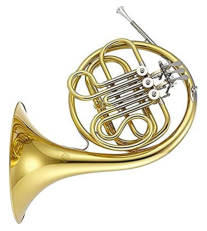

In [3]:
# Load the image
img = Image.open(IMG_PATH).convert("RGB")

# Visualize it
plt.imshow(img); plt.axis('off'); plt.show()

Instantiate the pretrained model and its pre-processor (this is important for your inference pipeline to work correctly).

In [4]:
model = repvgg_a0(pretrained=True).eval()

# Preprocessing
config = model.default_cfg
transform = Compose([
    Resize(config['input_shape'][1:], interpolation=InterpolationMode.BILINEAR),
    PILToTensor(),
    ConvertImageDtype(torch.float32),
    Normalize(config['mean'], config['std'])
])

And now we can go ahead with the inference!

In [5]:
# Preprocess the image
input_tensor = transform(img).unsqueeze(0)

# Inference
with torch.inference_mode():
    output = model(input_tensor)
probs = output.squeeze(0).softmax(dim=0)

In [6]:
# Print the result
print(model.default_cfg['classes'][probs.argmax()], probs.max().item())

French horn 0.8729506731033325


There are many other models available in Holocron. They are all designed for quality implementation, developer flexibility and being highly compatible with the PyTorch ecosystem. Here is how this model looks like:

In [7]:
print(model)

RepVGG(
  (features): Sequential(
    (0): Sequential(
      (0): RepBlock(
        (branches): ModuleList(
          (0): Sequential(
            (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Sequential(
            (0): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (activation): ReLU(inplace=True)
      )
      (1): RepBlock(
        (branches): ModuleList(
          (0): Sequential(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): Sequential(
            (0): Conv2d(48, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)

Some models have special features. In our case, RepVGG model can be reparametrized to maximize inference speed!

In [8]:
%timeit -n10 with torch.inference_mode(): output = model(input_tensor)

10 loops, best of 5: 182 ms per loop


In [9]:
# Let's reparametrize this now
model.reparametrize()

In [10]:
%timeit -n10 with torch.inference_mode(): output = model(input_tensor)

10 loops, best of 5: 124 ms per loop


And the model architecture has been updated

In [11]:
print(model)

RepVGG(
  (features): Sequential(
    (0): Sequential(
      (0): RepBlock(
        (branches): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU(inplace=True)
      )
      (1): RepBlock(
        (branches): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): RepBlock(
        (branches): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (activation): ReLU(inplace=True)
      )
      (1): RepBlock(
        (branches): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
      )
      (2): RepBlock(
        (branches): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU(inplace=True)
      )
    )
    (2): Sequential(
      (0): RepBlock(
        (branches): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
     